2025-08-20 21:32:59.659 Python[46536:1280519] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


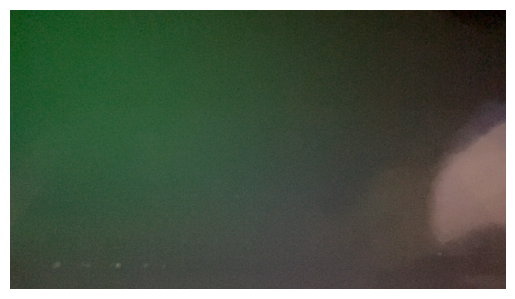

In [1]:
#for bills detection and counter
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk

class BillDetectorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Bill Detector & Counter")

        # Video Capture
        self.cap = cv2.VideoCapture(0)

        # Matplotlib figure for live feed
        self.fig, self.ax = plt.subplots()
        self.canvas = FigureCanvasTkAgg(self.fig, master=root)
        self.canvas.get_tk_widget().pack()

        # Bill count label
        self.bill_label = tk.Label(root, text="Total Bills: 0", font=("Arial", 14))
        self.bill_label.pack()

        self.update_frame()

        # Exit button
        self.exit_btn = tk.Button(root, text="Exit", command=self.close)
        self.exit_btn.pack()

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            return

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        # Edge detection
        edges = cv2.Canny(blur, 50, 150)

        # Dilate + close gaps
        kernel = np.ones((5, 5), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=2)
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        bill_count = 0
        output_img = frame.copy()

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < 8000:  # filter small shapes
                continue

            # Approximate contour to polygon
            approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)

            if len(approx) == 4:  # only rectangles
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)

                # Bills are rectangular, AR ~2.4, allow some tolerance
                if 2.0 < aspect_ratio < 2.6:
                    cv2.drawContours(output_img, [approx], -1, (255, 0, 0), 3)
                    cv2.putText(output_img, "Bill", (x, y - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
                    bill_count += 1

        # Update label
        self.bill_label.config(text=f"Total Bills: {bill_count}")

        # Convert to RGB and show in Tkinter
        output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
        self.ax.clear()
        self.ax.imshow(output_img_rgb)
        self.ax.axis("off")
        self.canvas.draw()

        self.root.after(30, self.update_frame)

    def close(self):
        self.cap.release()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = BillDetectorApp(root)
    root.mainloop()
